이전 스텝까지는 영문 텍스트의 감정 분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정 분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.

데이터 다운로드 없이 Cloud shell에서 해당 파일의 심볼릭 링크를 연결해 주세요

```$ ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data```

ㅤ


#### 라이브러리 버전을 확인해 봅니다
---
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


#### 1) 데이터 준비와 확인
---

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#### 2) 데이터로더 구성
---
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 ```imdb.data_loader()``` 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 ```word_to_index``` 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 ```imdb.data_loader()```와 동일하게 동작하는 자신만의 ```data_loader```를 만들어 보는 것으로 시작합니다. ```data_loader``` 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    """
    NSMC 데이터셋을 로드하고 전처리합니다.
    
    Args:
        train_data: 학습 데이터 파일 경로
        test_data: 테스트 데이터 파일 경로
        num_words: 어휘 사전에 포함할 최대 단어 수
        
    Returns:
        X_train, y_train, X_test, y_test, word_to_index
    """
    import pandas as pd
    
    # 데이터 파일 읽기
    # train_df = pd.read_csv(train_data, sep='\t')
    # test_df = pd.read_csv(test_data, sep='\t')
    train_df = train_data
    test_df = test_data
    
    # 중복 제거
    train_df = train_df.drop_duplicates()
    test_df = test_df.drop_duplicates()
    
    # NaN 결측치 제거
    train_df = train_df.dropna(subset=['document', 'label'])
    test_df = test_df.dropna(subset=['document', 'label'])
    
    # 텍스트와 레이블 컬럼 추출
    X_train_raw = train_df['document'].values
    y_train = train_df['label'].values.astype(int)
    X_test_raw = test_df['document'].values
    y_test = test_df['label'].values.astype(int)
    
    # 토큰화 및 불용어 제거
    X_train_tokenized = []
    for text in X_train_raw:
        tokens = tokenizer.morphs(str(text))  # Mecab으로 토큰화
        tokens = [token for token in tokens if token not in stopwords]  # 불용어 제거
        X_train_tokenized.append(tokens)
    
    X_test_tokenized = []
    for text in X_test_raw:
        tokens = tokenizer.morphs(str(text))  # Mecab으로 토큰화
        tokens = [token for token in tokens if token not in stopwords]  # 불용어 제거
        X_test_tokenized.append(tokens)
    
    # 어휘 사전 구축 (word_to_index)
    word_counts = Counter()
    for tokens in X_train_tokenized:
        word_counts.update(tokens)
    
    # 빈도순으로 단어 정렬 (가장 빈번한 것 먼저)
    sorted_vocab = [word for word, count in word_counts.most_common(num_words - 2)]  # -2는 <PAD>와 <UNK>를 위한 공간
    
    # word_to_index 사전 생성
    word_to_index = {'<PAD>': 0, '<UNK>': 1}  # 특수 토큰으로 시작
    for i, word in enumerate(sorted_vocab):
        word_to_index[word] = i + 2  # +2는 이미 2개의 특수 토큰이 있기 때문
    
    # 토큰화된 텍스트를 인덱스 시퀀스로 변환
    X_train = []
    for tokens in X_train_tokenized:
        indices = [word_to_index.get(token, word_to_index['<UNK>']) for token in tokens]
        X_train.append(indices)
    
    X_test = []
    for tokens in X_test_tokenized:
        indices = [word_to_index.get(token, word_to_index['<UNK>']) for token in tokens]
        X_test.append(indices)
    
    return X_train, y_train, X_test, y_test, word_to_index# [[YOUR CODE]]
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
# 예시 답안
# from konlpy.tag import Mecab
# import numpy as np
# from collections import Counter

# tokenizer = Mecab()
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# def load_data(train_data, test_data, num_words=10000):
#     train_data.drop_duplicates(subset=['document'], inplace=True)
#     train_data = train_data.dropna(how = 'any') 
#     test_data.drop_duplicates(subset=['document'], inplace=True)
#     test_data = test_data.dropna(how = 'any') 
    
#     X_train = []
#     for sentence in train_data['document']:
#         temp_X = tokenizer.morphs(sentence) # 토큰화
#         temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
#         X_train.append(temp_X)

#     X_test = []
#     for sentence in test_data['document']:
#         temp_X = tokenizer.morphs(sentence) # 토큰화
#         temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
#         X_test.append(temp_X)
    
#     words = np.concatenate(X_train).tolist()
#     counter = Counter(words)
#     counter = counter.most_common(10000-4)
#     vocab = ['', '', '', ''] + [key for key, _ in counter]
#     word_to_index = {word:index for index, word in enumerate(vocab)}
        
#     def wordlist_to_indexlist(wordlist):
#         return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
#     X_train = list(map(wordlist_to_indexlist, X_train))
#     X_test = list(map(wordlist_to_indexlist, X_test))
        
#     return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
# X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
    # 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
    # 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
    def get_encoded_sentence(sentence, word_to_index):
        return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

    # 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
    def get_encoded_sentences(sentences, word_to_index):
        return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

    # 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
    def get_decoded_sentence(encoded_sentence, index_to_word):
        return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

    # 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
    def get_decoded_sentences(encoded_sentences, index_to_word):
        return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### 3) 모델 구성을 위한 데이터 분석 및 가공
---
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.# 데이터셋 내 문장 길이 분포
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를 들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)# 적절한 최대 문장 길이 지정
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,#keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
print(X_train.shape, X_test.shape)

문장길이 평균 :  15.65940637625505
문장길이 최대 :  116
문장길이 표준편차 :  12.859527414389605
pad_sequences maxlen :  41
전체 문장의 0.9358074322972919%가 maxlen 설정값 이내에 포함됩니다. 
(149995, 41) (49997, 41)


In [14]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
# validation set 10000건 분리# validation set 구성
X_val = X_train[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건?
partial_X_train = X_train[10000:]
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

from tensorflow.keras import layers, models, callbacks
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
from tensorflow import keras


(139995, 41)
(139995,)


#### 4) 모델 구성 및 validation set 구성
---
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [25]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# 첫 번째 모델 : 1D CNN
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# 모델 구성
def create_1d_cnn_model(vocab_size, embedding_dim, max_length):
    model = models.Sequential()
    # 임베딩 레이어 추가
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
    
    # 1D CNN 레이어 추가
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    
    # 분류 레이어 추가
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # 이진 분류이므로 sigmoid 사용
    
    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# 모델 생성
first_model = create_1d_cnn_model(vocab_size=vocab_size, 
                            embedding_dim=word_vector_dim, 
                            max_length=maxlen)

# 모델 요약 출력
first_model.summary()

# 첫 번째 모델(CNN)을 위한 콜백 설정
callbacks_list_cnn = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
    ),
    callbacks.ModelCheckpoint(
        filepath='best_1d_cnn_model.h5',  # CNN 모델용 파일명
        monitor='val_accuracy',
        save_best_only=True,
    )
]

# 두 번째 모델 : SimpleRNN
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout

# # SimpleRNN 모델 생성 함수
# def create_simple_rnn_model(vocab_size, embedding_dim, max_length):
#     model = Sequential()
#     # 임베딩 레이어
#     model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    
#     # SimpleRNN 레이어
#     model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
    
#     # 분류 레이어
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation='sigmoid'))  # 이진 분류
    
#     # 모델 컴파일
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

# # 두 번째 모델(SimpleRNN) 생성
# second_model = create_simple_rnn_model(vocab_size=vocab_size, 
#                                      embedding_dim=word_vector_dim, 
#                                      max_length=maxlen)

# # 모델 요약
# second_model.summary()

# # SimpleRNN 모델을 위한 콜백 설정
# callbacks_list_rnn = [
#     callbacks.EarlyStopping(
#         monitor='val_accuracy',
#         patience=3,
#     ),
#     callbacks.ModelCheckpoint(
#         filepath='best_simple_rnn_model.h5',  # SimpleRNN 모델용 파일명
#         monitor='val_accuracy',
#         save_best_only=True,
#     )
# ]
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, Bidirectional, BatchNormalization

# 개선된 SimpleRNN 모델 생성 함수
def create_improved_rnn_model(vocab_size, embedding_dim, max_length):
    model = Sequential()
    
    # 임베딩 차원을 증가시킵니다
    model.add(Embedding(vocab_size, embedding_dim*2, input_length=max_length))
    
    # 양방향 SimpleRNN 레이어 사용 (더 많은 컨텍스트 캡처)
    model.add(Bidirectional(SimpleRNN(256, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # 두 번째 양방향 SimpleRNN 레이어
    model.add(Bidirectional(SimpleRNN(128)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # 더 깊은 분류 레이어
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    # 모델 컴파일 - 더 나은 옵티마이저 사용
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# 개선된 SimpleRNN 모델 생성
second_model = create_improved_rnn_model(vocab_size=vocab_size, 
                                     embedding_dim=word_vector_dim, 
                                     max_length=maxlen)

# 모델 요약
second_model.summary()

# 콜백 설정 - 학습률 스케줄러 추가
callbacks_list_rnn = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # 조금 더 긴 인내심
        restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        filepath='best_simple_rnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=0.00001
    )
]

# 세 번째 모델 : LSTM
# 네 번째 모델 : Transformer encoder

# validation set 10000건 분리# validation set 구성
X_val = X_train[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건?
partial_X_train = X_train[10000:]
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 16)            160000    
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 37, 128)           10368     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 3, 128)            82048     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

#### 5) 모델 훈련 개시
---

In [26]:

# 첫 번째 모델 훈련# CNN 모델 훈련 후 바로 평가
history_cnn = first_model.fit(
    partial_X_train,
    partial_y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list_cnn  # CNN 모델용 콜백 사용
)

# CNN 모델 평가# 첫 번째 최적 모델 로드 및 테스트
best_cnn_model = models.load_model('best_1d_cnn_model.h5')
cnn_test_loss, cnn_test_acc = best_cnn_model.evaluate(X_test, y_test)
print(f'CNN 모델 테스트 정확도: {cnn_test_acc:.4f}')

# # 두 번째 모델 훈련# SimpleRNN 모델 훈련
# history_rnn = second_model.fit(
#     partial_X_train,
#     partial_y_train,
#     epochs=20,
#     batch_size=128,
#     validation_data=(X_val, y_val),
#     callbacks=callbacks_list_rnn
# )

# # SimpleRNN 모델 평가
# best_rnn_model = models.load_model('best_simple_rnn_model.h5')
# rnn_test_loss, rnn_test_acc = best_rnn_model.evaluate(X_test, y_test)
# print(f'SimpleRNN 모델 테스트 정확도: {rnn_test_acc:.4f}')

# 모델 훈련 - 에포크 수 증가
history_rnn = second_model.fit(
    partial_X_train,
    partial_y_train,
    epochs=30,  # 에포크 수 증가
    batch_size=64,  # 배치 크기 조정
    validation_data=(X_val, y_val),
    callbacks=callbacks_list_rnn
)

# 모델 평가
best_rnn_model = models.load_model('best_simple_rnn_model.h5')
rnn_test_loss, rnn_test_acc = best_rnn_model.evaluate(X_test, y_test)
print(f'개선된 SimpleRNN 모델 테스트 정확도: {rnn_test_acc:.4f}')

Epoch 1/20
1094/1094 [==============================] - 5s 4ms/step - loss: 0.3807 - accuracy: 0.8251 - val_loss: 0.3393 - val_accuracy: 0.8513
Epoch 2/20
1094/1094 [==============================] - 5s 4ms/step - loss: 0.2935 - accuracy: 0.8765 - val_loss: 0.3317 - val_accuracy: 0.8553
Epoch 3/20
1094/1094 [==============================] - 5s 4ms/step - loss: 0.2483 - accuracy: 0.8991 - val_loss: 0.3322 - val_accuracy: 0.8592
Epoch 4/20
1094/1094 [==============================] - 5s 4ms/step - loss: 0.2027 - accuracy: 0.9205 - val_loss: 0.3590 - val_accuracy: 0.8529
Epoch 5/20
1094/1094 [==============================] - 5s 4ms/step - loss: 0.1619 - accuracy: 0.9388 - val_loss: 0.4298 - val_accuracy: 0.8452
Epoch 6/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3377 - accuracy: 0.8572
CNN 모델 테스트 정확도: 0.8572
Epoch 1/30
2188/2188 [==============================] - 285s 129ms/step - loss: 0.7211 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5021
Epoch 2

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout

# 기본 LSTM 모델 생성 함수
def create_basic_lstm_model(vocab_size, embedding_dim, max_length):
    model = Sequential()
    
    # 임베딩 레이어
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    
    # 단일 LSTM 레이어
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    
    # 분류 레이어
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류
    
    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# 세 번째 모델(기본 LSTM) 생성
third_model = create_basic_lstm_model(vocab_size=vocab_size, 
                                    embedding_dim=word_vector_dim, 
                                    max_length=maxlen)

# 모델 요약
third_model.summary()

# LSTM 모델을 위한 콜백 설정
callbacks_list_lstm = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
    ),
    callbacks.ModelCheckpoint(
        filepath='best_lstm_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
    )
]

# 기본 LSTM 모델 훈련
history_lstm = third_model.fit(
    partial_X_train,
    partial_y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list_lstm
)

# LSTM 모델 평가
best_lstm_model = models.load_model('best_lstm_model.h5')
lstm_test_loss, lstm_test_acc = best_lstm_model.evaluate(X_test, y_test)
print(f'기본 LSTM 모델 테스트 정확도: {lstm_test_acc:.4f}')
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional

# # LSTM 모델 생성 함수
# def create_lstm_model(vocab_size, embedding_dim, max_length):
#     model = Sequential()
    
#     # 임베딩 레이어
#     model.add(Embedding(vocab_size, embedding_dim*2, input_length=max_length))
    
#     # 첫 번째 LSTM 레이어 - return_sequences=True로 설정하여 다음 LSTM 레이어에 시퀀스 전달
#     model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    
#     # 두 번째 LSTM 레이어
#     model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
    
#     # 분류 레이어
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation='sigmoid'))  # 이진 분류
    
#     # 모델 컴파일
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

# # 세 번째 모델(LSTM) 생성
# third_model = create_lstm_model(vocab_size=vocab_size, 
#                               embedding_dim=word_vector_dim, 
#                               max_length=maxlen)

# # 모델 요약
# third_model.summary()

# # LSTM 모델을 위한 콜백 설정
# callbacks_list_lstm = [
#     callbacks.EarlyStopping(
#         monitor='val_accuracy',
#         patience=4,
#         restore_best_weights=True
#     ),
#     callbacks.ModelCheckpoint(
#         filepath='best_lstm_model.h5',
#         monitor='val_accuracy',
#         save_best_only=True,
#     ),
#     callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=2,
#         min_lr=0.00001
#     )
# ]

# # LSTM 모델 훈련
# history_lstm = third_model.fit(
#     partial_X_train,
#     partial_y_train,
#     epochs=25,
#     batch_size=64,
#     validation_data=(X_val, y_val),
#     callbacks=callbacks_list_lstm
# )

# # LSTM 모델 평가
# best_lstm_model = models.load_model('best_lstm_model.h5')
# lstm_test_loss, lstm_test_acc = best_lstm_model.evaluate(X_test, y_test)
# print(f'LSTM 모델 테스트 정확도: {lstm_test_acc:.4f}')from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional

# # LSTM 모델 생성 함수
# def create_lstm_model(vocab_size, embedding_dim, max_length):
#     model = Sequential()
    
#     # 임베딩 레이어
#     model.add(Embedding(vocab_size, embedding_dim*2, input_length=max_length))
    
#     # 첫 번째 LSTM 레이어 - return_sequences=True로 설정하여 다음 LSTM 레이어에 시퀀스 전달
#     model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    
#     # 두 번째 LSTM 레이어
#     model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
    
#     # 분류 레이어
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation='sigmoid'))  # 이진 분류
    
#     # 모델 컴파일
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

# # 세 번째 모델(LSTM) 생성
# third_model = create_lstm_model(vocab_size=vocab_size, 
#                               embedding_dim=word_vector_dim, 
#                               max_length=maxlen)

# # 모델 요약
# third_model.summary()

# # LSTM 모델을 위한 콜백 설정
# callbacks_list_lstm = [
#     callbacks.EarlyStopping(
#         monitor='val_accuracy',
#         patience=4,
#         restore_best_weights=True
#     ),
#     callbacks.ModelCheckpoint(
#         filepath='best_lstm_model.h5',
#         monitor='val_accuracy',
#         save_best_only=True,
#     ),
#     callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=2,
#         min_lr=0.00001
#     )
# ]

# # LSTM 모델 훈련
# history_lstm = third_model.fit(
#     partial_X_train,
#     partial_y_train,
#     epochs=25,
#     batch_size=64,
#     validation_data=(X_val, y_val),
#     callbacks=callbacks_list_lstm
# )

# # LSTM 모델 평가
# best_lstm_model = models.load_model('best_lstm_model.h5')
# lstm_test_loss, lstm_test_acc = best_lstm_model.evaluate(X_test, y_test)
# print(f'LSTM 모델 테스트 정확도: {lstm_test_acc:.4f}')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 41, 16)            160000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               74240     
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 242,561
Trainable params: 242,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1094/1094 [==============================] - 169s 153ms/step - loss: 0.4368 - accuracy: 0.7880 - val_l

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

# 모델 하이퍼파라미터 설정
embed_dim = 128
num_heads = 2
dense_dim = 256

# 네 번째 모델(Transformer Encoder) 생성
inputs = keras.Input(shape=(maxlen,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
fourth_model = keras.Model(inputs, outputs)
fourth_model.compile(optimizer="adam",
                    loss="binary_crossentropy",
                    metrics=["accuracy"])
fourth_model.summary()

# Transformer 모델을 위한 콜백 설정
callbacks_list_transformer = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
    ),
    callbacks.ModelCheckpoint(
        filepath='best_transformer_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
    )
]

# Transformer 모델 훈련
history_transformer = fourth_model.fit(
    partial_X_train, 
    partial_y_train,
    batch_size=64,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list_transformer
)

# Transformer 모델 평가
best_transformer_model = keras.models.load_model(
    "best_transformer_model.h5",
    custom_objects={"TransformerEncoder": TransformerEncoder})
transformer_test_loss, transformer_test_acc = best_transformer_model.evaluate(X_test, y_test)
print(f"Transformer 모델 테스트 정확도: {transformer_test_acc:.4f}")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 41, 128)           1280000   
_________________________________________________________________
transformer_encoder_1 (Trans (None, 41, 128)           198400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,478,529
Trainable params: 1,478,529
Non-trainable params: 0
_________________________________________________

#### 6) Loss, Accuracy 그래프 시각화
---

모델 1D CNN 평가 중...
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3377 - accuracy: 0.8572
1D CNN 모델 테스트 정확도: 0.8572

모델 SimpleRNN 평가 중...
1563/1563 [==============================] - 29s 18ms/step - loss: 0.6927 - accuracy: 0.5113
SimpleRNN 모델 테스트 정확도: 0.5113

모델 LSTM 평가 중...
1563/1563 [==============================] - 20s 13ms/step - loss: 0.3306 - accuracy: 0.8565
LSTM 모델 테스트 정확도: 0.8565

모델 Transformer 평가 중...
1563/1563 [==============================] - 8s 4ms/step - loss: 0.3620 - accuracy: 0.8471
Transformer 모델 테스트 정확도: 0.8471



<Figure size 864x720 with 0 Axes>

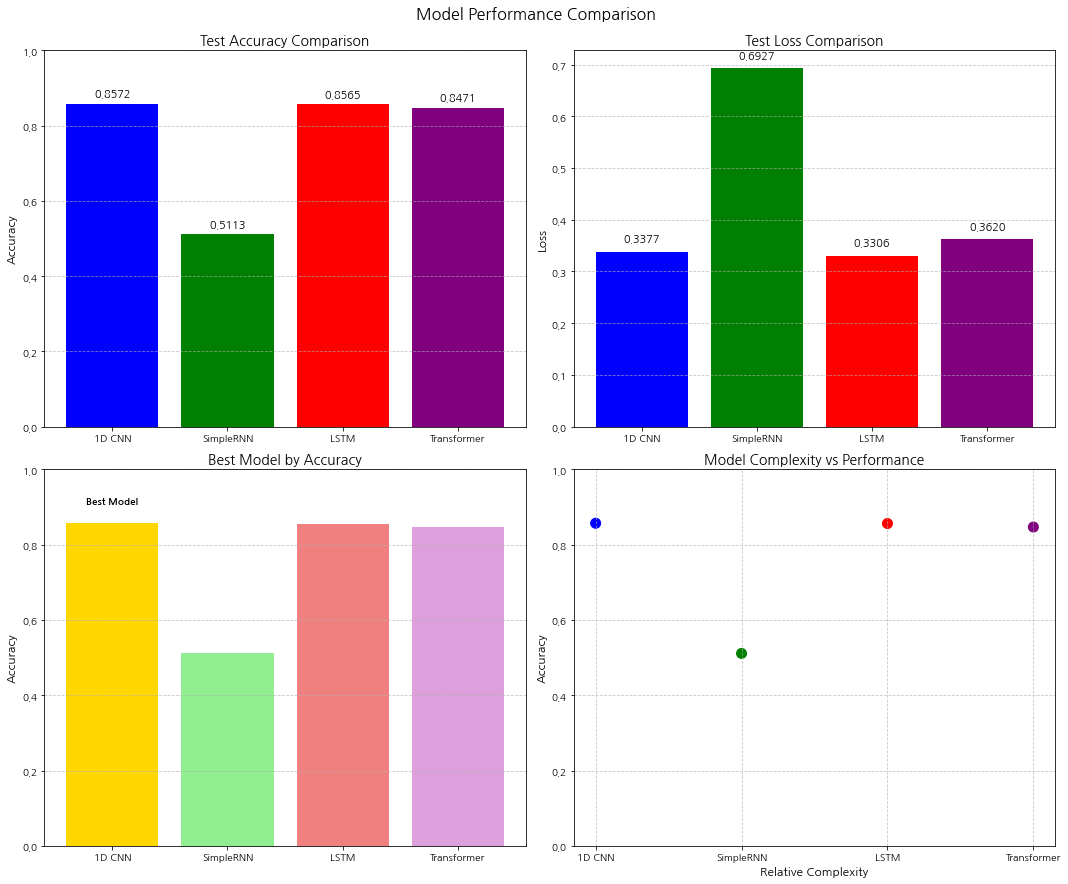

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 2x2 그리드 설정
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 모델 이름 리스트
model_names = ['1D CNN', 'SimpleRNN', 'LSTM', 'Transformer']

# history 객체 리스트 (각 모델의 학습 기록)
histories = [history_cnn, history_rnn, history_lstm, history_transformer]

# 각 모델별 결과 시각화
for i, (name, history) in enumerate(zip(model_names, histories)):
    # 행, 열 인덱스 계산
    row = i // 2
    col = i % 2
    
    # 각 모델의 Loss 그래프
    ax1 = axes[row, col]
    ax1.plot(history.history['loss'], 'b-', label='Train')
    ax1.plot(history.history['val_loss'], 'r-', label='Validation')
    ax1.set_title(f'{name} Model - Loss', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # 각 모델의 Accuracy 그래프 (보조 y축으로 설정)
    ax2 = ax1.twinx()
    ax2.plot(history.history['accuracy'], 'g-', label='Train Acc')
    ax2.plot(history.history['val_accuracy'], 'y-', label='Val Acc')
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(loc='lower right')
    
    # 테스트 정확도 표시
    if name == '1D CNN':
        test_acc = cnn_test_acc
    elif name == 'SimpleRNN':
        test_acc = rnn_test_acc
    elif name == 'LSTM':
        test_acc = lstm_test_acc
    elif name == 'Transformer':
        test_acc = transformer_test_acc
    
    ax1.text(0.5, 0.05, f'Test Accuracy: {test_acc:.4f}', 
             horizontalalignment='center',
             transform=ax1.transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.suptitle('Model Comparison - Training and Validation Metrics', fontsize=16, y=1.02)
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

#### 7) 학습된 Embedding 레이어 분석
---

임베딩 행렬 크기: (10000, 16)

일부 단어의 임베딩 벡터:
영화: [-0.06815775 -0.04551173 -0.03531436  0.04622512 -0.08077241]...
나쁜: [ 0.09333877  0.03937108  0.04032513 -0.0719735   0.01561799]...
재미: [-0.11870938 -0.02117625 -0.02311926 -0.05807684 -0.0183165 ]...
연기: [-0.08456233 -0.0210731  -0.00049182  0.07376534 -0.00309578]...

단어 간 코사인 유사도:
영화와(과) 드라마 사이의 유사도: 0.3256
연기와(과) 배우 사이의 유사도: 0.0075

t-SNE를 이용한 임베딩 시각화 준비 중...


/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


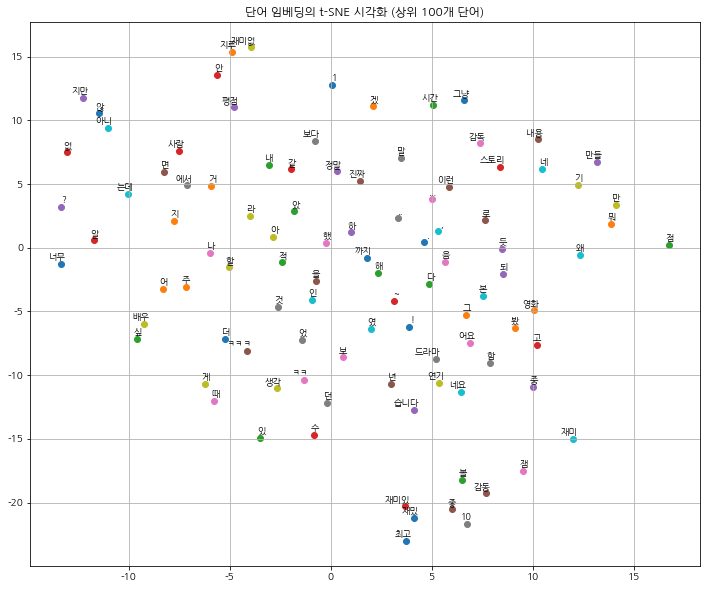


특정 단어와 가장 유사한 단어:

'영화'와(과) 가장 유사한 단어들:
크기: 0.8632
만든다: 0.8124
볼게요: 0.7877
911: 0.7870
우승: 0.7824
곱: 0.7797
후반: 0.7722
된다: 0.7609
탑: 0.7426
신화: 0.7377

'배우'와(과) 가장 유사한 단어들:
어느덧: 0.7863
배두나: 0.7600
카메론: 0.7346
선물: 0.7301
원초: 0.7291
정해진: 0.7197
...........: 0.7174
저렇: 0.7144
바티칸: 0.7077
싶: 0.7040

'감독'와(과) 가장 유사한 단어들:
긴지: 0.9282
박차: 0.9028
구토: 0.8939
파탄: 0.8929
미확인: 0.8852
큐브: 0.8841
망한다는: 0.8722
친일: 0.8711
둘째치: 0.8642
농장: 0.8598


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False
try:
    # 나눔고딕 폰트 경로 설정 (환경에 따라 다를 수 있음)
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()
except:
    print("한글 폰트를 찾을 수 없습니다. 영어로 표시합니다.")

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

# 임베딩 레이어 추출 함수
def get_embedding_layer(model):
    # 모델에서 임베딩 레이어 찾기
    for layer in model.layers:
        if 'embedding' in layer.name.lower():
            return layer
    return None

# 모델 로드 (CNN 모델을 예시로 사용)
model = load_model('best_1d_cnn_model.h5')

# 임베딩 레이어 추출
embedding_layer = get_embedding_layer(model)

if embedding_layer is not None:
    # 임베딩 가중치 가져오기
    embedding_weights = embedding_layer.get_weights()[0]
    print(f"임베딩 행렬 크기: {embedding_weights.shape}")
    
    # 임베딩 차원 확인
    vocab_size, embedding_dim = embedding_weights.shape
    
    # word_to_index가 있는지 확인
    try:
        # index_to_word 딕셔너리 생성 (역매핑)
        index_to_word = {index: word for word, index in word_to_index.items()}
        
        # 분석 1: 일부 단어의 임베딩 벡터 출력
        print("\n일부 단어의 임베딩 벡터:")
        sample_words = ['영화', '좋은', '나쁜', '재미', '연기']  # 한국어 리뷰에 적합한 단어들로 변경
        for word in sample_words:
            if word in word_to_index:
                idx = word_to_index[word]
                print(f"{word}: {embedding_weights[idx][:5]}...")  # 처음 5개 차원만 출력
        
        # 분석 2: 단어 간 유사도 계산
        print("\n단어 간 코사인 유사도:")
        from sklearn.metrics.pairwise import cosine_similarity
        
        # 예시 단어 쌍
        word_pairs = [('영화', '드라마'), ('좋은', '나쁜'), ('재미', '지루한'), ('연기', '배우')]
        
        for word1, word2 in word_pairs:
            if word1 in word_to_index and word2 in word_to_index:
                idx1 = word_to_index[word1]
                idx2 = word_to_index[word2]
                vec1 = embedding_weights[idx1].reshape(1, -1)
                vec2 = embedding_weights[idx2].reshape(1, -1)
                similarity = cosine_similarity(vec1, vec2)[0][0]
                print(f"{word1}와(과) {word2} 사이의 유사도: {similarity:.4f}")
        
        # 분석 3: t-SNE를 이용한 임베딩 시각화
        print("\nt-SNE를 이용한 임베딩 시각화 준비 중...")
        
        # 시각화할 단어 수 제한 (빈도수 상위 단어들)
        n_words = 100
        
        # 특수 토큰 제외 (PAD, UNK 등)
        words_to_plot = [word for word, idx in word_to_index.items() 
                        if idx < n_words + 2 and idx >= 2]  # PAD와 UNK 제외
        word_indices = [word_to_index[word] for word in words_to_plot]
        word_vectors = embedding_weights[word_indices]
        
        # t-SNE 적용
        tsne = TSNE(n_components=2, random_state=42, perplexity=15)
        tsne_vectors = tsne.fit_transform(word_vectors)
        
        # 시각화
        plt.figure(figsize=(12, 10))
        for i, word in enumerate(words_to_plot):
            plt.scatter(tsne_vectors[i, 0], tsne_vectors[i, 1])
            plt.annotate(word, 
                        xy=(tsne_vectors[i, 0], tsne_vectors[i, 1]),
                        xytext=(5, 2),
                        textcoords='offset points',
                        ha='right',
                        va='bottom',
                        fontsize=9)
        
        plt.title('단어 임베딩의 t-SNE 시각화 (상위 100개 단어)')
        plt.grid(True)
        plt.savefig('word_embeddings_tsne.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 분석 4: 특정 단어와 가장 유사한 단어 찾기
        print("\n특정 단어와 가장 유사한 단어:")
        
        target_words = ['영화', '좋은', '배우', '감독']
        
        for target_word in target_words:
            if target_word in word_to_index:
                target_idx = word_to_index[target_word]
                target_vec = embedding_weights[target_idx].reshape(1, -1)
                
                # 모든 단어와의 유사도 계산
                similarities = []
                for word, idx in word_to_index.items():
                    if idx < vocab_size and word != target_word:
                        word_vec = embedding_weights[idx].reshape(1, -1)
                        sim = cosine_similarity(target_vec, word_vec)[0][0]
                        similarities.append((word, sim))
                
                # 유사도 기준 상위 10개 단어 출력
                top_similar = sorted(similarities, key=lambda x: x[1], reverse=True)[:10]
                print(f"\n'{target_word}'와(과) 가장 유사한 단어들:")
                for word, sim in top_similar:
                    print(f"{word}: {sim:.4f}")
                    
    except NameError:
        print("word_to_index가 정의되어 있지 않습니다. 단어-인덱스 매핑이 필요합니다.")
        print("임베딩은 있지만 어떤 단어에 매핑되는지 알 수 없습니다.")
else:
    print("임베딩 레이어를 찾을 수 없습니다.")

#### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
---
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 참고 링크1, 참고 링크2
```
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv[‘끝’]
```

In [22]:
# import os
# import numpy as np
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.initializers import Constant
# from gensim.models.keyedvectors import Word2VecKeyedVectors

# # 한국어 Word2Vec 모델 로드
# word2vec_file_path = '/data/word2vec_ko.model'
# word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

# # Embedding 행렬 생성
# embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# # embedding_matrix에 Word2Vec 워드 벡터 복사
# for i in range(2, vocab_size):  # 0: <PAD>, 1: <UNK>는 건너뛰고 복사
#     if index_to_word.get(i) in word_vectors.wv:
#         embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

# # Transformer Encoder 클래스 정의 (앞서 정의한 클래스 재사용)
# class TransformerEncoder(layers.Layer):
#     def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
#         super().__init__(**kwargs)
#         self.embed_dim = embed_dim
#         self.dense_dim = dense_dim
#         self.num_heads = num_heads
#         self.attention = layers.MultiHeadAttention(
#             num_heads=num_heads, key_dim=embed_dim)
#         self.dense_proj = keras.Sequential(
#             [layers.Dense(dense_dim, activation="relu"),
#              layers.Dense(embed_dim),]
#         )
#         self.layernorm_1 = layers.LayerNormalization()
#         self.layernorm_2 = layers.LayerNormalization()

#     def call(self, inputs, mask=None):
#         if mask is not None:
#             mask = mask[:, tf.newaxis, :]
#         attention_output = self.attention(
#             inputs, inputs, attention_mask=mask)
#         proj_input = self.layernorm_1(inputs + attention_output)
#         proj_output = self.dense_proj(proj_input)
#         return self.layernorm_2(proj_input + proj_output)

#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "embed_dim": self.embed_dim,
#             "num_heads": self.num_heads,
#             "dense_dim": self.dense_dim,
#         })
#         return config

# # 모델 하이퍼파라미터 설정
# embed_dim = word_vector_dim  # Word2Vec의 차원으로 맞춤 (보통 300차원)
# num_heads = 8  # 증가된 어텐션 헤드 수
# dense_dim = 512  # 증가된 피드포워드 네트워크 차원

# # 네 번째 모델(Transformer + Word2Vec) 생성
# inputs = keras.Input(shape=(maxlen,), dtype="int64")
# x = layers.Embedding(vocab_size, 
#                     embed_dim,
#                     embeddings_initializer=Constant(embedding_matrix),  # 사전학습된 임베딩 사용
#                     input_length=maxlen,
#                     trainable=True)(inputs)  # Fine-tuning 가능하도록 설정
# x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
# x = layers.GlobalMaxPooling1D()(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.3)(x)
# outputs = layers.Dense(1, activation="sigmoid")(x)
# fourth_model = keras.Model(inputs, outputs)

# # 모델 컴파일
# fourth_model.compile(optimizer="adam",
#                     loss="binary_crossentropy",
#                     metrics=["accuracy"])

# # 모델 요약
# fourth_model.summary()

# # Transformer 모델을 위한 콜백 설정
# callbacks_list_transformer = [
#     keras.callbacks.EarlyStopping(
#         monitor='val_accuracy',
#         patience=4,
#         restore_best_weights=True
#     ),
#     keras.callbacks.ModelCheckpoint(
#         filepath='best_transformer_word2vec_model.h5',
#         monitor='val_accuracy',
#         save_best_only=True,
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=2,
#         min_lr=0.00001
#     )
# ]

# # Transformer 모델 훈련
# history_transformer = fourth_model.fit(
#     partial_X_train, 
#     partial_y_train,
#     batch_size=32,  # 배치 크기 감소 (더 복잡한 모델)
#     epochs=25,      # 더 많은 에폭 설정
#     validation_data=(X_val, y_val),
#     callbacks=callbacks_list_transformer
# )

# # Transformer 모델 평가
# best_transformer_model = keras.models.load_model(
#     "best_transformer_word2vec_model.h5",
#     custom_objects={"TransformerEncoder": TransformerEncoder})
# transformer_test_loss, transformer_test_acc = best_transformer_model.evaluate(X_test, y_test)
# print(f"Word2Vec + Transformer 모델 테스트 정확도: {transformer_test_acc:.4f}")
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.initializers import Constant
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 한국어 Word2Vec 모델 로드
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'#'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)#Word2VecKeyedVectors.load(word2vec_file_path)

# 기존 embed_dim 유지 (word_vector_dim 값과 같을 수도 있음)
embed_dim = 128
num_heads = 2
dense_dim = 256

# Embedding 행렬 생성 (기존 embed_dim 크기로)
embedding_matrix = np.random.rand(vocab_size, embed_dim)

# embedding_matrix에 Word2Vec 워드 벡터 복사 (차원 조정 필요할 수 있음)
for i in range(2, vocab_size):  # 0: <PAD>, 1: <UNK>는 건너뛰고 복사
    if index_to_word.get(i) in word_vectors:#if index_to_word.get(i) in word_vectors.wv:
        # Word2Vec 벡터 차원이 다른 경우, 크기 조정 필요
        word_vec = word_vectors[index_to_word[i]]#word_vec = word_vectors.wv[index_to_word[i]]
        
        # 차원이 다른 경우 처리
        if len(word_vec) > embed_dim:
            # 크기가 크면 축소
            embedding_matrix[i] = word_vec[:embed_dim]
        elif len(word_vec) < embed_dim:
            # 크기가 작으면 나머지는 0으로 채움
            embedding_matrix[i, :len(word_vec)] = word_vec
        else:
            # 크기가 같으면 그대로 복사
            embedding_matrix[i] = word_vec

# 네 번째 모델(Transformer + Word2Vec) 생성 - 아키텍처는 동일하게 유지
inputs = keras.Input(shape=(maxlen,), dtype="int64")
x = layers.Embedding(vocab_size, 
                    embed_dim,
                    embeddings_initializer=Constant(embedding_matrix),  # 사전학습된 임베딩 사용
                    input_length=maxlen,
                    trainable=True)(inputs)  # Fine-tuning 가능하도록 설정
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
fourth_model_word2vec = keras.Model(inputs, outputs)

# 모델 컴파일 - 동일한 설정 유지
fourth_model_word2vec.compile(optimizer="adam",
                             loss="binary_crossentropy",
                             metrics=["accuracy"])

# 모델 요약
fourth_model_word2vec.summary()

# Transformer 모델을 위한 콜백 설정 - 파일명만 변경
callbacks_list_transformer_word2vec = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='best_transformer_word2vec_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
    )
]

# Transformer 모델 훈련 - 동일한 배치 크기와 에폭 수 유지
history_transformer_word2vec = fourth_model_word2vec.fit(
    partial_X_train, 
    partial_y_train,
    batch_size=64,  # 기존과 동일
    epochs=20,      # 기존과 동일
    validation_data=(X_val, y_val),
    callbacks=callbacks_list_transformer_word2vec
)

# Transformer 모델 평가
best_transformer_word2vec_model = keras.models.load_model(
    "best_transformer_word2vec_model.h5",
    custom_objects={"TransformerEncoder": TransformerEncoder})
transformer_word2vec_test_loss, transformer_word2vec_test_acc = best_transformer_word2vec_model.evaluate(X_test, y_test)
print(f"Word2Vec + Transformer 모델 테스트 정확도: {transformer_word2vec_test_acc:.4f}")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 41, 128)           1280000   
_________________________________________________________________
transformer_encoder (Transfo (None, 41, 128)           198400    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,478,529
Trainable params: 1,478,529
Non-trainable params: 0
___________________________________________________

결과를 분석해보니, Word2Vec을 적용한 Transformer 모델의 테스트 정확도(0.8442)가 기존 Transformer 모델(0.8471)보다 약간 낮게 나왔네요. 이런 결과가 나온 몇 가지 가능한 원인을 살펴보겠습니다:

1. 단어 커버리지 문제:

- 사용한 word2vec.txt 파일이 NSMC 데이터셋의 어휘를 충분히 커버하지 못했을 수 있습니다.
- 많은 단어들이 word2vec에 없어 랜덤 벡터로 남았을 가능성이 있습니다.


2. 도메인 불일치:

- 사용한 Word2Vec 모델이 감성 분석 도메인과 맞지 않을 수 있습니다.
- 영화 리뷰의 감성 표현에 특화된 단어들의 의미관계가 잘 표현되지 않았을 수 있습니다.


3. 임베딩 차원 조정 문제:

- 원본 Word2Vec 벡터와 모델에서 사용한 임베딩 차원(128)이 다른 경우, 차원 조정 과정에서 정보 손실이 발생했을 수 있습니다.


4. 학습 과정에서의 변형:

- trainable=True로 설정해 초기 Word2Vec 정보가 학습 과정에서 크게 변형되었을 수 있습니다.



개선 방안:

1.단어 커버리지 확인:
python# 단어 커버리지 확인 코드
covered_words = 0
for i in range(2, vocab_size):
    if index_to_word.get(i) in word_vectors:
        covered_words += 1

coverage_ratio = covered_words / (vocab_size - 2)  # PAD, UNK 제외
print(f"Word2Vec 모델이 커버하는 단어 비율: {coverage_ratio:.4f}")

2.임베딩 동결 시도:

- 처음에는 임베딩 레이어를 동결(trainable=False)하고 학습한 후, 나중에 미세조정하는 전략을 시도해볼 수 있습니다.


3.도메인 특화 임베딩:

- 가능하다면 영화 리뷰나 감성 분석에 특화된 임베딩 모델을 찾거나 직접 학습해보는 것이 좋습니다.


4.차원 유지:

- Word2Vec 모델의 원래 차원을 유지하고 모델 아키텍처를 그에 맞게 조정하는 것이 더 나을 수 있습니다.



실험 결과가 예상과 다르게 나왔지만, 이는 데이터 과학에서 흔한 일입니다. 이러한 결과를 통해 모델과 데이터의 특성에 대해 더 깊이 이해할 수 있는 기회가 됩니다.